In [181]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from utils import mnist_reader
import torch 
import torch.nn as nn
import os
import matplotlib.image as mpimg
import time

In [122]:
# improve the ploting style
rcParams['font.family'] = 'Times New Roman'
rcParams['font.size'] = 18
rcParams['mathtext.fontset'] = 'stix'

In [3]:
dtype = torch.float32

x_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
x_valid, y_valid = mnist_reader.load_mnist('data/fashion', kind='t10k')
print(max(y_train), min(y_train))

x_train, y_train_raw, x_valid, y_valid_raw = torch.tensor(x_train, dtype=dtype), torch.tensor(y_train, dtype=dtype), torch.tensor(x_valid, dtype=dtype), torch.tensor(y_valid,dtype=dtype)

9 0


In [4]:
print(min(y_train.item()))

ValueError: can only convert an array of size 1 to a Python scalar

In [ ]:
y_train = torch.zeros(y_train_raw.shape[0], 10)
for i,y in enumerate(y_train_raw):
    j = int(y.item())
    y_train[i,j] = 1

y_valid = torch.zeros(y_valid_raw.shape[0], 10)
for i,y in enumerate(y_valid_raw):
    j = int(y.item())
    y_valid[i,j] = 1 
    
print(y_train.shape, y_valid.shape)

tensor(0.)
torch.Size([60000, 10]) torch.Size([10000, 10])


In [ ]:
print(y_train.shape, y_train[0:5])
print(y_valid.shape, y_valid[0:5])

torch.Size([60000, 10]) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
torch.Size([10000, 10]) tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])


In [ ]:
X_sample = X_train[0].reshape(28,28)
print(X_sample.shape)

(28, 28)


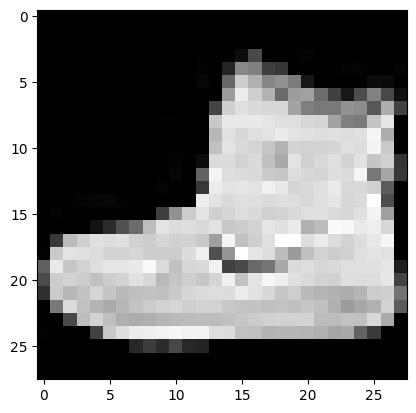

In [ ]:
plt.imshow(X_sample, cmap='gray')
plt.show()

In [195]:
dtype = torch.float32

def ReLU(x):
    return torch.max(torch.tensor(0),x)

def ReLU_derivative(x):
    return (x>0).to(dtype)

def softmax_derivative(s):
    """
    s : Tensor de shape (n_batch, num_classes), déjà softmaxé
    Renvoie : Tensor de shape (n_batch, num_classes, num_classes) contenant la jacobienne de softmax pour chaque échantillon
    """
    n, C = s.shape
    jacobians = torch.zeros(n, C, C, dtype=s.dtype) # Initialisation du tenseur Jacobien (n_batch, num_classes, num_classes) => (i,j,k) = dérivée de softmax au logit j du ième batch par rapport au logit k du même batch
    for i in range(n):  # Pour chaque échantillon du batch, on calcule la jacobienne de softmax
        si = s[i].unsqueeze(1)  # shape (C, 1) # vecteur softmax(logits) pour la i-ème donnée du batch
        jacobians[i] = torch.diagflat(si) - torch.mm(si,si.t()) # calcul de la jacobienne (matrice des dérivées croisées) de softmax au point z_i = vect(logits_i) # shape (C, C) -> Indice du Jacobien : lignes, Indice des logits : colonnes
    return jacobians



class two_layer_NN(nn.Module):
    def __init__(self,input_dimension,hidden_1_size,number_of_classes,lr=1e-3, reg1 = 0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 100):
        """
        Constructor of the two-layer neural network class.
        """
        super(two_layer_NN,self).__init__()
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.number_of_classes = number_of_classes
        self.lr = lr
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        self.training_time = 0
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = self.eps_init*torch.randn(number_of_classes, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(number_of_classes,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        output = self.softmax(z2) # output layer # shape (n_data, number_of_classes)
        return output, z2, h1, z1
    
    # coef_iter est a ajusté en fonction du seuil kappa_eff d'apprentissage des données.
    def train_layers(self, x_train, y_train, x_valid, y_valid, coef_iter = 1, lr=1e-3, reg1=0, reg2=0, eps_init=1, fraction_batch=0.01, observation_rate = 100, train_layer_1 = True, train_layer_2 = True):
        start = time.time()
        unwanted_time = 0
        self.architecture = "2 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - coef_iter = " + str(coef_iter) + " - lr = " + str(lr) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch) 
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        kappa_max = 1 + coef_iter
        max_iter = self.input_dimension**(kappa_max)
        print("max_iter", max_iter)
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_minibatches = int(max_iter / self.fraction_batch) # Nombre de minibatches utilisés pour l'apprentissage de la première couche
        for i in range(N_minibatches):
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            # Calcul de la prédiction
            output, z2, h1, z1 = self.forward(x_minibatch)
            if i % self.observation_rate == 0:    
                # Suivi de l'apprentissage
                unwanted_time_begin = time.time()
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                unwanted_time += time.time() - unwanted_time_begin
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            # Calcul des gradients
            grad_output = output - y_minibatch
            grad_z2 = torch.einsum('noz, no->nz', softmax_derivative(output), grad_output) # shape(n_data, num_classes) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h1 = torch.mm(grad_z2, self.W2)  # shape (n_data, hidden_1_size)
            grad_z1 = grad_h1*ReLU_derivative(z1) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0] # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = torch.mean(grad_z1, dim=0).unsqueeze(1) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0] # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = torch.mean(grad_z2, dim=0).unsqueeze(1)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)
            if train_layer_2:
                self.W2 -= self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_W2/(self.eps_init**2) +self.reg2*self.W2)
                self.b2 -= self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_b2/(self.eps_init**2) + self.reg2*self.b2)
            self.training_time = time.time() - start - unwanted_time
        return "Training done"
   
class three_layer_NN(nn.Module):
    def __init__(self, input_dimension, hidden_1_size, hidden_2_size, number_of_classes,lr=0.01, reg1 =0, reg2 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10):
        """
        Constructor of the three-layer neural network class.
        """
        super(three_layer_NN,self).__init__()
        self.architecture = ""
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.hidden_2_size = hidden_2_size
        self.number_of_classes = number_of_classes
        self.lr = lr
        self.eps_init = eps_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        self.training_time = 0
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = eps_init*torch.randn(hidden_2_size, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.W3 = eps_init*torch.randn(number_of_classes, hidden_2_size, dtype=dtype)/np.sqrt(hidden_2_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = eps_init*(2*torch.rand(hidden_2_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.b3 = eps_init*(2*torch.rand(number_of_classes,1,dtype=dtype)-1)
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        h2 = ReLU(z2) # hidden neurons layer 2
        z3 = (torch.mm(self.W3,h2.t()) + self.b3).t()
        output = self.softmax(z3) # output layer # shape (n_data, number_of_classes)
        return output, z3, h2, z2, h1, z1
    
    # coef_iter est a ajusté en fonction du seuil kappa_eff d'apprentissage des données.
    def train_layers(self, x_train, y_train, x_valid, y_valid, coef_iter = 1, lr=1e-3, reg1 = 0, reg2 = 0, reg3 = 0, eps_init=1, fraction_batch=0.01, observation_rate = 10, train_layer_1 = True, train_layer_2 = True, train_layer_3 = True):
        start = time.time()
        unwanted_time = 0
        self.architecture = "3 layers" + " - Training first layer : " + str(train_layer_1) + " - Training second layer : " + str(train_layer_2) + " - Training third layer : " + str(train_layer_3) + " - coef_iter = " + str(coef_iter) + " - lr = " + str(lr) + " - reg1 = " + str(reg1) + " - reg2 = " + str(reg2) + " - eps_init = " + str(eps_init) + " - fraction_batch = " + str(fraction_batch)
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        self.observation_rate = observation_rate
        kappa_max = 1 + coef_iter
        max_iter = self.input_dimension**(kappa_max)
        print("max_iter", max_iter)
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_minibatches = int(max_iter / self.fraction_batch) # Nombre de minibatches utilisés pour l'apprentissage
        for i in range(N_minibatches):
            
            # Tirage aléatoire d'un minibatch
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            
            # Calcul de la prédiction
            output, z3, h2, z2, h1, z1 = self.forward(x_minibatch)
            
            if i % self.observation_rate == 0:
                unwanted_time_begin = time.time() 
            # Suivi de l'apprentissage
                training_loss = torch.mean(0.5*(output - y_minibatch)**2) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss pour chaque classe
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2)
                self.training_loss_trajectory.append(training_loss.item())
                self.validation_loss_trajectory.append(validation_loss.item())
                accuracy = torch.mean((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", training_loss.item(), "Validation loss", validation_loss.item(), "Accuracy", accuracy.item())
                unwanted_time += time.time() - unwanted_time_begin
            
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 + reg3*(||W3||**2 + ||b3||**2) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            # Calcul des gradients
            grad_output = output - y_minibatch
            grad_z3 = torch.einsum('no,noz->nz',grad_output,softmax_derivative(output)) # shape (n_data, num_classes) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h2 = torch.mm(grad_z3, self.W3) # shape (n_data, hidden_2_size)
            grad_z2 = grad_h2*ReLU_derivative(z2) # shape(n_data, hidden_2_size)         
            grad_h1 = torch.mm(grad_z2, self.W2)  # shape (n_data, hidden_1_size)
            grad_z1 = grad_h1*ReLU_derivative(z1) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0] # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = torch.mean(grad_z1, dim=0).unsqueeze(1) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0] # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = torch.mean(grad_z2, dim=0).unsqueeze(1)
            # Calcul de la moyenne empirique de dLoss/dW3 par backpropagation
            grad_W3 = torch.mm(grad_z3.t(),h2)/x_minibatch.shape[0]
            # Calcul de la moyenne empirique du gradient dLoss/db" par backpropagation
            grad_b3 = torch.mean(grad_z3,dim=0).unsqueeze(1)
            
            # Mise à jours des paramètres de la première couche
            if train_layer_1:
                self.W1 -= self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/(self.eps_init**2) + self.reg1*self.W1) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
                self.b1 -= self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/(self.eps_init**2) + self.reg1*self.b1)
            if train_layer_2:
                self.W2 -= self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_W2/(self.eps_init**2) +self.reg2*self.W2)
                self.b2 -= self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_b2/(self.eps_init**2) + self.reg2*self.b2)
            if train_layer_3:
                self.W3 -= self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_W3/(eps_init**2) + self.reg3*self.W3)
                self.b3 -= self.lr*(torch.sqrt(torch.tensor(self.hidden_2_size))*grad_b3/(eps_init**2) + self.reg3*self.b3)
            self.training_time = time.time() - start - unwanted_time
        return "Training done"


In [196]:
model_2_layer = two_layer_NN(784,512,10)

In [197]:
model_2_layer.train_layers(x_train,y_train, x_valid, y_valid, 1, 1e-3, 0, 0, 1, 0.01, 10)

max_iter 614656
Iteration 0 Training loss 0.09224962443113327 Validation loss 0.09098991006612778 Accuracy 0.07339999824762344
Iteration 10 Training loss 0.08876975625753403 Validation loss 0.08949742466211319 Accuracy 0.09619999676942825
Iteration 20 Training loss 0.08129862695932388 Validation loss 0.08108747750520706 Accuracy 0.1817999929189682
Iteration 30 Training loss 0.07469066977500916 Validation loss 0.07456433773040771 Accuracy 0.24959999322891235
Iteration 40 Training loss 0.07427629083395004 Validation loss 0.07315141707658768 Accuracy 0.26499998569488525
Iteration 50 Training loss 0.07086373120546341 Validation loss 0.07350478321313858 Accuracy 0.2623000144958496
Iteration 60 Training loss 0.07267791777849197 Validation loss 0.07260712236166 Accuracy 0.2720000147819519
Iteration 70 Training loss 0.07455632835626602 Validation loss 0.07307075709104538 Accuracy 0.266400009393692
Iteration 80 Training loss 0.073715440928936 Validation loss 0.07260952889919281 Accuracy 0.27239

KeyboardInterrupt: 

In [204]:
model_3_trained_layer = three_layer_NN(784, 512, 256, 10)

In [205]:
model_3_trained_layer.train_layers(x_train, y_train, x_valid, y_valid, 1, 1e-3, 0, 0, 0, 1, 0.01, 10)

max_iter 614656
Iteration 0 Training loss 0.09037034213542938 Validation loss 0.0911577120423317 Accuracy 0.06849999725818634
Iteration 10 Training loss 0.09045189619064331 Validation loss 0.08996108174324036 Accuracy 0.09989999979734421
Iteration 20 Training loss 0.08905860036611557 Validation loss 0.08990060538053513 Accuracy 0.10000000149011612
Iteration 30 Training loss 0.08181218057870865 Validation loss 0.08094397187232971 Accuracy 0.188400000333786
Iteration 40 Training loss 0.08204544335603714 Validation loss 0.0807521715760231 Accuracy 0.1906999945640564
Iteration 50 Training loss 0.07834230363368988 Validation loss 0.08011805266141891 Accuracy 0.19679999351501465
Iteration 60 Training loss 0.08536844700574875 Validation loss 0.08033107221126556 Accuracy 0.19529999792575836
Iteration 70 Training loss 0.07998275011777878 Validation loss 0.0800274908542633 Accuracy 0.19830000400543213
Iteration 80 Training loss 0.07854796200990677 Validation loss 0.08001963049173355 Accuracy 0.1

KeyboardInterrupt: 

In [210]:
model_3_layer_1_untrained = three_layer_NN(784, 512, 256, 10)

In [ ]:
model_3_layer_1_untrained.train_layers(x_train, y_train, x_valid, y_valid, 1, 1e-3, 0, 0, 0, 1, 0.01, 10, True, False, True)

max_iter 614656
Iteration 0 Training loss 0.09681342542171478 Validation loss 0.09679381549358368 Accuracy 0.01549999974668026
Iteration 10 Training loss 0.07025577127933502 Validation loss 0.071634441614151 Accuracy 0.27709999680519104
Iteration 20 Training loss 0.07483749836683273 Validation loss 0.07187289744615555 Accuracy 0.2770000100135803
Iteration 30 Training loss 0.07151298224925995 Validation loss 0.0703793466091156 Accuracy 0.2897999882698059
Iteration 40 Training loss 0.0717371255159378 Validation loss 0.07081842422485352 Accuracy 0.2879999876022339
Iteration 50 Training loss 0.06561345607042313 Validation loss 0.06775342673063278 Accuracy 0.31869998574256897
Iteration 60 Training loss 0.06806135922670364 Validation loss 0.06635008752346039 Accuracy 0.33340001106262207
Iteration 70 Training loss 0.06591656804084778 Validation loss 0.06590680032968521 Accuracy 0.3375000059604645
Iteration 80 Training loss 0.06448914855718613 Validation loss 0.06582719832658768 Accuracy 0.338

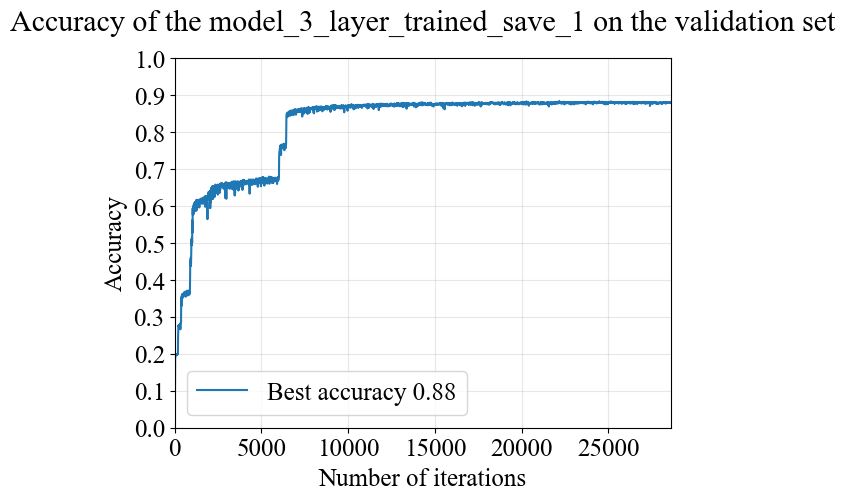

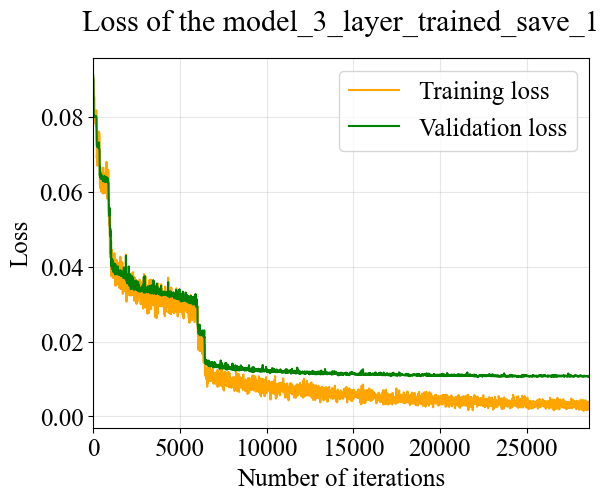

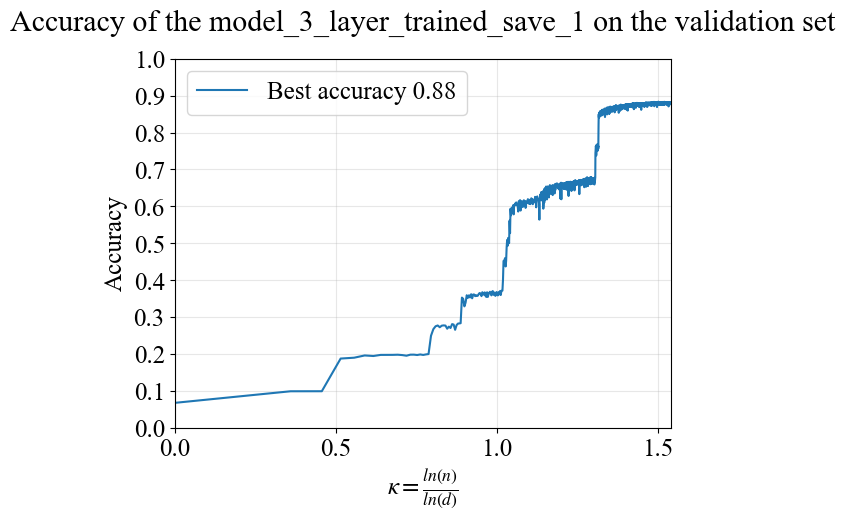

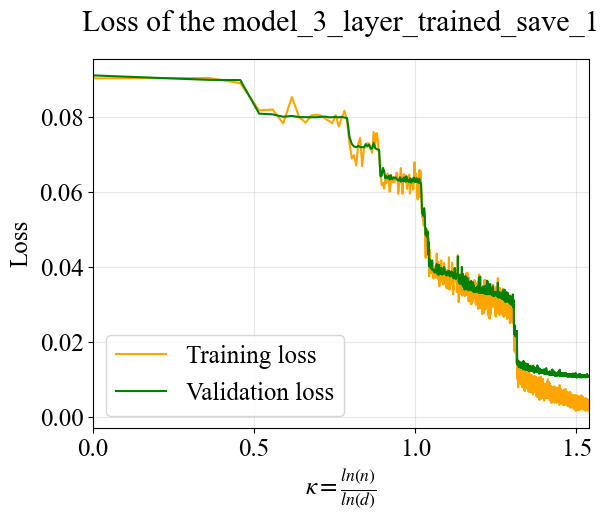

In [209]:
save = True
date = "_27_04_25"
if save :
    # Save the model
    model = model_3_trained_layer
    model_name = "model_3_layer_trained_save_1"
    save_path = "Classifiers/" + model_name + date + "/"
    os.makedirs(save_path, exist_ok=True)
    torch.save(model , save_path + model_name + ".pt")


    # Save Architecture
    with open(save_path + "architecture.txt", "w", encoding="utf-8") as f:
        f.write(model.architecture + str(model.training_time))

    # Save performances of the model
    os.makedirs(save_path + "figures/", exist_ok=True) 
    # Plot accuracy = f(n)
    plt.plot(np.linspace(0, len(model.accuracy_trajectory)*model.observation_rate, len(model.accuracy_trajectory)), model.accuracy_trajectory, label = "Best accuracy " + str(np.round(np.max(model.accuracy_trajectory), 2)))
    plt.xlim(0, len(model.accuracy_trajectory)*model.observation_rate)
    plt.ylim(0,1)
    plt.yticks(np.linspace(0,1,11))
    plt.xlabel("Number of iterations")  
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.3)
    plt.title("Accuracy of the " + model_name + " on the validation set", pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/accuracy_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/accuracy_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((np.linspace(0, len(model.accuracy_trajectory)*model.observation_rate, len(model.accuracy_trajectory)), model.accuracy_trajectory)) 
    np.savetxt(save_path +"figures/accuracy_of_" + model_name + ".txt", data, delimiter =",", header="n,accuracy")
    plt.show() 
    
    # Plot training and validation loss = f(n)
    plt.plot(np.linspace(0,len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory)), model.training_loss_trajectory, label = "Training loss", color = "orange")
    plt.plot(np.linspace(0,len(model.validation_loss_trajectory)*model.observation_rate, len(model.validation_loss_trajectory)), model.validation_loss_trajectory, label="Validation loss", color = "green")
    plt.xlim(0, len(model.training_loss_trajectory)*model.observation_rate)
    plt.xlabel("Number of iterations")  
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.title("Loss of the " + model_name, pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/loss_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/loss_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((np.linspace(0,len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory)), model.training_loss_trajectory))
    np.savetxt(save_path + "figures/loss_training_" + model_name + ".txt", data, delimiter=",", header="n, training_loss")
    plt.show()
    
    # Plot accuracy = f(kappa)
    kappa = [np.log(n)/np.log(model.input_dimension) for n in np.linspace(1, len(model.accuracy_trajectory)*model.observation_rate+1, len(model.accuracy_trajectory))]
    plt.plot(kappa, model.accuracy_trajectory, label = "Best accuracy " + str(np.round(np.max(model.accuracy_trajectory), 2)))
    plt.xlim(0, np.max(kappa))
    plt.ylim(0,1)
    plt.yticks(np.linspace(0,1,11))
    plt.xlabel(r"$\kappa  = \frac{ln(n)}{ln(d)}$")  
    plt.ylabel("Accuracy")
    plt.grid(alpha=0.3)
    plt.title("Accuracy of the " + model_name + " on the validation set", pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/kappa_accuracy_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/kappa_accuracy_of_" + model_name + ".svg", bbox_inches='tight')
    data = np.column_stack((kappa, model.accuracy_trajectory))
    np.savetxt(save_path + "figures/kappa_accuracy_" + model_name + ".txt", data, delimiter=",", header="kappa, accuracy")
    plt.show()
    
    # Plot training and validation loss
    kappa = [np.log(n)/np.log(model.input_dimension) for n in np.linspace(1, len(model.training_loss_trajectory)*model.observation_rate, len(model.training_loss_trajectory))]
    plt.plot(kappa, model.training_loss_trajectory, label = "Training loss", color = "orange")
    plt.plot(kappa, model.validation_loss_trajectory, label = "Validation loss", color = "green")
    plt.xlim(0, np.max(kappa))
    plt.xlabel(r"$\kappa  = \frac{ln(n)}{ln(d)}$")  
    plt.ylabel("Loss")
    plt.grid(alpha=0.3)
    plt.title("Loss of the " + model_name, pad = 20)
    plt.legend()
    plt.savefig(save_path + "figures/kappa_loss_of_" + model_name + ".png", bbox_inches='tight')
    plt.savefig(save_path + "figures/kappa_loss_of_" + model_name + ".svg", bbox_inches='tight')
    data_training = np.column_stack((kappa, model.training_loss_trajectory))
    np.savetxt(save_path + "figures/kappa_loss_training_" + model_name + ".txt", data_training, delimiter=",", header="kappa, training_loss")
    data_validation = np.column_stack((kappa, model.validation_loss_trajectory))
    np.savetxt(save_path + "figures/kappa_loss_validation_" + model_name + ".txt", data_validation, delimiter=",", header="kappa, validation_loss")
    plt.show()
    
else:
    print("No save")


In [ ]:
os.makedirs("datas\models")

0.001
tensor(0.8692)


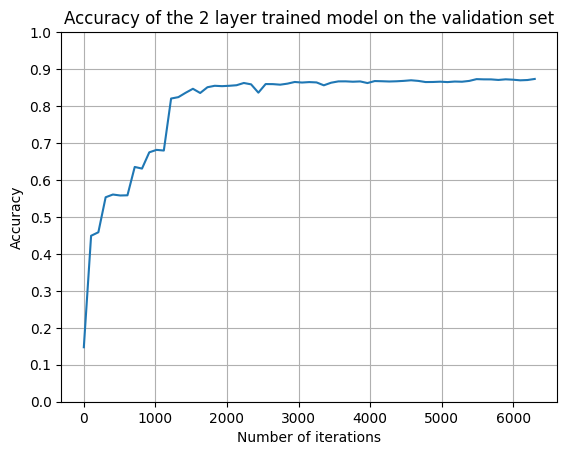

<Figure size 640x480 with 0 Axes>

In [ ]:
# Import model and plot performances

model_name = "model_2_layer_trained_save_1"
assessed_model = torch.load("datas/models/model_2_layer_save_1.pt", weights_only=False)

# Details of the model
print(assessed_model.architecture)

# Plots of performances
accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".png")
plt.imshow(accuracy)
kappa_accuracy = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_accuracy_of_" + model_name + ".png")
plt.imshow(kappa_accuracy)
loss = mpimg.imread("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".png")
plt.imshow(loss)
kappa_loss = mpimg.imread("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".png")
plt.imshow(kappa_loss)
plt.show()

# Import datas
accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/accuracy_of_" + model_name + ".txt", delimiter=",", skiprows=1)
loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)
kappa_accuracy_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_accuracy_" + model_name + ".txt", delimiter=",", skiprows=1)
kappa_loss_data = np.loadtxt("Classifiers/" + model_name + "/figures/kappa_loss_of_" + model_name + ".txt", delimiter=",", skiprows=1)


In [ ]:
dtype = torch.float32

def ReLU(x):
    return torch.max(torch.tensor(0),x)

def ReLU_derivative(x):
    return (x>0).to(dtype)

def softmax_derivative(s):
    """
    s : Tensor de shape (n_batch, num_classes), déjà softmaxé
    Renvoie : Tensor de shape (n_batch, num_classes, num_classes) contenant la jacobienne de softmax pour chaque échantillon
    """
    n, C = s.shape
    jacobians = torch.zeros(n, C, C, dtype=s.dtype) # Initialisation du tenseur Jacobien (n_batch, num_classes, num_classes) => (i,j,k) = dérivée de softmax au logit j du ième batch par rapport au logit k du même batch
    for i in range(n):  # Pour chaque échantillon du batch, on calcule la jacobienne de softmax
        si = s[i].unsqueeze(1)  # shape (C, 1) # vecteur softmax(logits) pour la i-ème donnée du batch
        jacobians[i] = torch.diagflat(si) - torch.mm(si,si.t()) # calcul de la jacobienne (matrice des dérivées croisées) de softmax au point z_i = vect(logits_i) # shape (C, C) -> Indice du Jacobien : lignes, Indice des logits : colonnes
    return jacobians



class three_layer_NN(nn.Module):
    def __init__(self,input_dimension,hidden_1_size,number_of_classes,lr=1e-3, reg1 = 0, reg2 = 0, reg3 = 0, esp_init = 1, fraction_batch=0.01):
        """
        Constructor of the two-layer neural network class.
        """
        super(two_layer_NN,self).__init__()
        self.input_dimension = input_dimension
        self.hidden_1_size = hidden_1_size
        self.number_of_classes = number_of_classes
        self.lr = lr
        self.eps_init = esp_init
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.fraction_batch = fraction_batch
        self.W1 = torch.randn(hidden_1_size, input_dimension, dtype=dtype) / np.sqrt(input_dimension) # will lead to a sum over "input_dimension" coefficients, thus to normalise the norm, we divide by "input_dimension"
        self.W2 = self.eps_init*torch.randn(number_of_classes, hidden_1_size, dtype=dtype ) / np.sqrt(hidden_1_size)
        self.b1 = (2*torch.rand(hidden_1_size,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-1,1)
        self.b2 = esp_init*(2*torch.rand(number_of_classes,1,dtype=dtype)-1) # les biais sont initialisés aléatoirement selon une loi uniforme U(-eps,eps) # on mutiplie par eps pour que les biais soient petits et ainsi éviter l'explosion ou le vanishing des gradients
        self.softmax = nn.Softmax(dim=1) # on applique la fonction softmax sur la dimension 1 (c'est à dire sur les classes) # dim=0 correspond à la dimension des batchs
        self.validation_loss_trajectory = []
        self.training_loss_trajectory = []
        self.accuracy_trajectory = []
        # Activation = ReLU
        # Loss = 0.5*MSE
        # Optimizer = GD
        
    def forward(self, x):
        z1 = (torch.mm(self.W1, x.t()) + self.b1).t() # shape (n_data, hidden_1_size) # logits layer 1
        h1 = ReLU(z1)  # hidden neurons layer 1
        z2 = (torch.mm(self.W2, h1.t()) + self.b2).t() # shape (n_data, number_of_classes ) # logits layer 2
        h2 = ReLU(z2) # # hidden neurons layer 2
        z3 = torch.mm(self.W3, h2.t() + self.b3)
        output = self.softmax(z2) # output layer # shape (n_data, number_of_classes)
        return output, z2, h1, z1
    
    # coef_iter est a ajusté en fonction du seuil kappa_eff d'apprentissage des données.
    def train_layers(self, x_train, y_train, x_valid, y_valid, coef_iter = 1, lr=1e-3, reg1 = 0, reg2 = 0, reg3 = 0, eps_init=0.2, fraction_batch=1e-2, train_layer1=True, train_layer2=True, train_layer3=True):
        self.lr = lr
        self.reg1 = reg1
        self.reg2 = reg2
        self.reg3 = reg3
        self.eps_init = eps_init
        self.fraction_batch = fraction_batch
        kappa_max = 1 + coef_iter
        max_iter = self.input_dimension**(kappa_max)
        print("max_iter", max_iter)
        minibatch_size = int(x_train.shape[0]*self.fraction_batch)
        N_minibatches = int(max_iter / self.fraction_batch) # Nombre de minibatches utilisés pour l'apprentissage de la première couche
        for i in range(N_minibatches):
            indices_minibatch = torch.randperm(x_train.shape[0])[:minibatch_size]
            x_minibatch, y_minibatch = x_train[indices_minibatch], y_train[indices_minibatch] # sélection un lot de données aléatoires parmis les données d'entrainement 
            # Calcul de la prédiction
            output, z2, h1, z1 = self.forward(x_minibatch)
            # Suivi de l'apprentissage
            if i % 100 == 0:
                training_loss = torch.mean(0.5*(output - y_minibatch)**2, dim=0) # shape (number_of_classes, 1) # on divise par le nombre d'échantillons du minibatch pour obtenir la moyenne empirique de la loss
                overall_training_loss = torch.mean(training_loss,dim=0)
                validation_loss = torch.mean(0.5*(self.forward(x_valid)[0] - y_valid)**2, dim=0)
                overall_validation_loss = torch.mean(validation_loss,dim=0)
                self.training_loss_trajectory.append(overall_training_loss.item())
                self.validation_loss_trajectory.append(overall_validation_loss.item())
                accuracy = torch.mean((torch.argmax(self.forward(x_valid)[0], dim=1) == torch.argmax(y_valid, dim=1)).to(dtype))
                self.accuracy_trajectory.append(accuracy.item())
                print("Iteration", i, "Training loss", overall_training_loss.item(), "Validation loss", overall_validation_loss.item(), "Accuracy", accuracy.item())
            # Loss = 0.5*(output - y_batch)**2 + reg1*||W1||**2 + reg1*||b1||**2 + reg2*||W2||**2 + reg2*||b2||**2 # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1) # on ne pénalise pas les biais car ils sont déjà petits (initialisés aléatoirement entre -1 et 1)
            # Calcul des gradients
            grad_output = output - y_minibatch
            grad_z2 = torch.einsum('noz, no->nz', softmax_derivative(output), grad_output) # shape(n_data, num_classes) # produit du gradient de la loss par rapport aux outputs shape(n_data, num_classes) et du tenseur des Jacobiennes des outputs (n_data, num_classes, num_classes) # On multiplie la dimension des outputs (=dL/dy_i) du gradient avec la dimensions des outputs de la jacobienne (=dy_i/dz_j) pour obtenir le grad_z2 (dL(y_i)/dy_i)*(dy_i/dz_j)
            grad_h1 = torch.mm(grad_z2, self.W2)  # shape (n_data, hidden_1_size)
            grad_z1 = grad_h1*ReLU_derivative(z1) # shape (n_data, hidden_1_size)
            
            # Calcul de la moyenne empirique de dLoss/dW1 par backpropagation
            grad_W1 = torch.mm(grad_z1.t(), x_minibatch)/x_minibatch.shape[0] # shape (hidden_1_size, input_dimension)
            # Calcul de la moyenne empirique de dLoss/db1 par backpropagation
            grad_b1 = torch.mean(grad_z1, dim=0).unsqueeze(1) 
            # Calcul de la moyenne empirique de dLoss/dW2 par backpropagation
            grad_W2 = torch.mm(grad_z2.t(), h1)/x_minibatch.shape[0] # shape (number_of_classes, hidden_1_size)
            # Calcul de la moyenne empirique de dLoss/db2 par backpropagation
            grad_b2 = torch.mean(grad_z2, dim=0).unsqueeze(1)
            
            # Mise à jours des paramètres de la première couche
            self.W1 -= self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_W1/self.eps_init**2 + self.reg1*self.W1) # on multiplie par (hidden_1_size)**2 pour compenser la dilution du gradient avec l'augmentation de la taille de la couche de neurone (correction de la variance) # on divise par eps^2 pour compenser la faible amplitude des couches suivantes (Réajustement d'échelle) # on pénalise l'augmentation de la norme des poids de W1
            self.b1 -= self.lr*(torch.sqrt(torch.tensor(self.hidden_1_size))*grad_b1/self.eps_init**2 + self.reg1*self.b1)
            self.W2 -= self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_W2/self.eps_init**2 +self.reg2*self.W2)
            self.b2 -= self.lr*(torch.sqrt(torch.tensor(self.number_of_classes))*grad_b2/self.eps_init**2 + self.reg2*self.b2)
        return "Training done"
   
